# Imports

In [23]:
import zipfile
import os
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn.utils.rnn import pad_sequence
import random
from librosa.effects import pitch_shift as librosa_pitch_shift
from librosa.effects import time_stretch as librosa_time_stretch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

if torch.cuda.is_available():
    device = torch.device("cuda")  # Set device to GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Data Pre-Processing

In [24]:
def extract_logmel_features(path, sr=16000, n_mels=40):
    y, sr = librosa.load(path, sr=sr)
    if len(y) == 0:
        y = np.zeros(1024, dtype=np.float32)

    y, _ = librosa.effects.trim(y, top_db=20)

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, n_fft=min(1024, len(y))
    )
    logmel = librosa.power_to_db(mel).T
    delta = librosa.feature.delta(logmel, order=1)
    delta2 = librosa.feature.delta(logmel, order=2)
    logmel = np.concatenate([logmel, delta, delta2], axis=1)
    logmel = (logmel - np.mean(logmel, axis=0)) / (np.std(logmel, axis=0) + 1e-9)
    return torch.tensor(logmel, dtype=torch.float32)


In [25]:
class CoswaraFusionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.voice_types = ["breathing-deep", "cough-heavy", "counting-normal", "vowel-a"]
        self.data = []

        # Construct voice_b paths
        self.voice_paths = {
            v: os.path.join(v, "Voice_b") for v in self.voice_types
        }

        for label_name in ["Positive", "Negative"]:
            label = 1 if label_name == "Positive" else 0
            # pick files from cough folder as anchor
            folder = os.path.join(self.voice_paths["cough-heavy"], label_name)
            files = [f for f in os.listdir(folder) if f.endswith(".wav")]
            for f in files:
                base_id = f.split("_")[0]  # e.g. 00xKcQMmcAhX8CODgBBLOe7Dm0T2
                entry = {}
                valid = True
                for v in self.voice_types:
                    target_path = os.path.join(
                        self.voice_paths[v], label_name, f"{base_id}_{v}.wav"
                    )
                    if os.path.exists(target_path):
                        entry[v] = target_path
                    else:
                        valid = False
                        break
                if valid:
                    entry["label"] = label
                    self.data.append(entry)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        label = torch.tensor(entry["label"], dtype=torch.long)
        feats = []
        for v in self.voice_types:
            feats.append(extract_logmel_features(entry[v],n_mels=30))
        return feats, label  # list of 4 tensors, label

In [26]:
def fusion_collate_fn(batch):
    # Unzip batch into separate modality lists
    data, labels = zip(*batch)
    breathing_list, cough_list, count_list, vowel_list = zip(*data)

    # Pad each modality
    breathing_padded = pad_sequence(breathing_list, batch_first=True)  # (B, T_max, F)
    cough_padded = pad_sequence(cough_list, batch_first=True)
    count_padded = pad_sequence(count_list, batch_first=True)
    vowel_padded = pad_sequence(vowel_list, batch_first=True)

    # Stack labels
    labels = torch.stack(labels)

    return breathing_padded, cough_padded, count_padded, vowel_padded, labels


In [27]:
class FusionNet(nn.Module):
    def __init__(self, num_models=4, num_classes=2):
        super().__init__()
        self.fc = nn.Linear(num_models * num_classes, num_classes)

    def forward(self, probs_list):
        # probs_list: list of 4 probability tensors [batch, num_classes]
        concat = torch.cat(probs_list, dim=1)
        out = self.fc(concat)
        return out


In [28]:
def load_pretrained_models():
    model_paths = {
        "breathing": "gru_breathing_b.pth",
        "cough": "gru_cough_b.pth",
        "count": "gru_counting_b.pth",
        "vowel": "gru_vowel_b.pth",
    }
    models = {}
    for k, p in model_paths.items():
        models[k] = torch.load(p, map_location=device)
        models[k].eval()
    return models

In [29]:
root = "Coswara"  # your dataset main folder
dataset = CoswaraFusionDataset(root)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

In [30]:
train_loader = DataLoader(train_set, batch_size=13, shuffle=True,collate_fn=fusion_collate_fn)
val_loader = DataLoader(val_set, batch_size=13, shuffle=False,collate_fn=fusion_collate_fn)

# Model

In [31]:
class CovidGRU(nn.Module):
    def __init__(self, input_dim=120, hidden_dim=128, num_layers=1, fc_dim=64, 
                 num_classes=2, dropout=0.4, bidirectional=False):
        super().__init__()

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        gru_out_dim = hidden_dim * (2 if bidirectional else 1)

        self.fc1 = nn.Linear(gru_out_dim, fc_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        # x: (batch, time, feature_dim)
        out, _ = self.gru(x)  # out: (batch, time, hidden_dim)

        # Mask to ignore zero-padded frames
        mask = (x.abs().sum(dim=-1) != 0).float()  # (batch, time)

        # Compute effective lengths to avoid divide-by-zero
        lengths = mask.sum(dim=1, keepdim=True).clamp(min=1e-6)

        # Weighted mean pooling
        pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / lengths  # (batch, hidden_dim)

        # Fully connected classifier
        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

In [32]:
pretrained = load_pretrained_models()
fusion_model = FusionNet(num_models=4, num_classes=2)

C:\Users\david\AppData\Local\Temp\ipykernel_27696\3791348744.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[k] = torch.load(p, map_location=device)


# Training

In [33]:
def evaluate_fusion(fusion_model, pretrained_models, dataloader, device="cpu"):
    fusion_model.eval()
    correct, total, total_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for val_data in dataloader:
            labels=val_data[-1]
            feats = val_data[:-1]
            labels = labels.to(device)
            probs_list = []
            for i, (key, model) in enumerate(pretrained_models.items()):
                x = feats[i].to(device)
                out = model(x)
                probs = F.softmax(out, dim=1)
                probs_list.append(probs)

            fusion_out = fusion_model(probs_list)
            loss = criterion(fusion_out, labels)
            total_loss += loss.item()
            preds = fusion_out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc

In [34]:
def train_fusion(fusion_model, pretrained_models, train_loader, val_loader,
                 device="cpu", epochs=10):
    optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    fusion_model.to(device)

    for epoch in range(epochs):
        fusion_model.train()
        total_loss, correct, total = 0, 0, 0

        for data in train_loader:
            labels=data[-1]
            feats = data[:-1]
            labels = labels.to(device)
            probs_list = []
            for i, (key, model) in enumerate(pretrained_models.items()):
                x = feats[i].to(device)
                # print(x.shape)
                with torch.no_grad():
                    out = model(x)
                    probs = F.softmax(out, dim=1)
                probs_list.append(probs)

            fusion_out = fusion_model(probs_list)
            loss = criterion(fusion_out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = fusion_out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)

        val_loss, val_acc = evaluate_fusion(fusion_model, pretrained_models, val_loader, device)
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss={train_loss:.4f} Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    return fusion_model

In [35]:
trained_fusion = train_fusion(
        fusion_model, pretrained, train_loader, val_loader,
        device=device, epochs=10
    )

Epoch 01 | Train Loss=0.8514 Acc=0.2874 | Val Loss=0.6924 Acc=0.6291
Epoch 02 | Train Loss=0.6176 Acc=0.7364 | Val Loss=0.5460 Acc=0.7918
Epoch 03 | Train Loss=0.5181 Acc=0.7880 | Val Loss=0.4731 Acc=0.8265
Epoch 04 | Train Loss=0.4632 Acc=0.8221 | Val Loss=0.4303 Acc=0.8482
Epoch 05 | Train Loss=0.4296 Acc=0.8351 | Val Loss=0.4031 Acc=0.8568
Epoch 06 | Train Loss=0.4081 Acc=0.8422 | Val Loss=0.3853 Acc=0.8395
Epoch 07 | Train Loss=0.3928 Acc=0.8433 | Val Loss=0.3721 Acc=0.8482
Epoch 08 | Train Loss=0.3826 Acc=0.8454 | Val Loss=0.3645 Acc=0.8460
Epoch 09 | Train Loss=0.3756 Acc=0.8476 | Val Loss=0.3570 Acc=0.8482
Epoch 10 | Train Loss=0.3703 Acc=0.8471 | Val Loss=0.3535 Acc=0.8568


# Evaluation

In [44]:
trained_fusion.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for val_data in val_loader:
        labels=val_data[-1]
        feats = val_data[:-1]
        labels = labels.to(device)
        probs_list = []
        for i, (key, model) in enumerate(pretrained.items()):
            x = feats[i].to(device)
            out = model(x)
            probs = F.softmax(out, dim=1)
            probs_list.append(probs)
    
        fusion_out = trained_fusion(probs_list)
        
        preds = fusion_out.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [45]:
# torch.save(model, "fusion-net_b.pth")

In [46]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.93      0.90       339
    Positive       0.76      0.66      0.71       122

    accuracy                           0.86       461
   macro avg       0.82      0.80      0.81       461
weighted avg       0.85      0.86      0.85       461



In [47]:
cm = confusion_matrix(all_labels, all_preds)

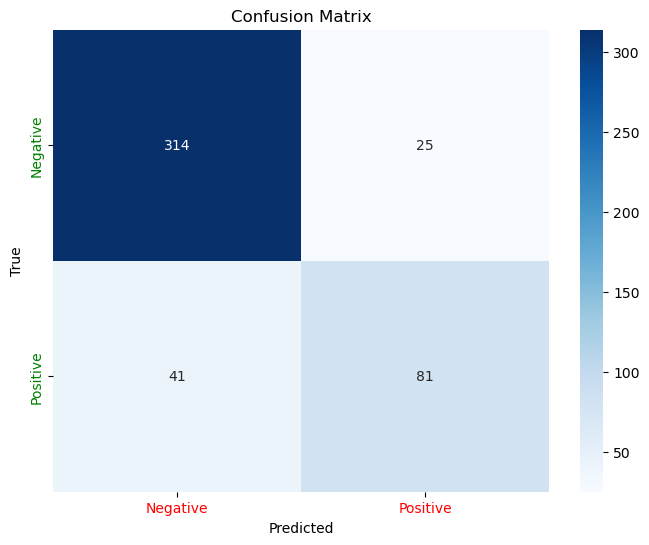

In [49]:
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=['Negative', 'Positive'],
                 yticklabels=['Negative', 'Positive'])

# Set tick label colors
for tick_label in ax.get_xticklabels():
    tick_label.set_color('red')  # X-axis labels in red

for tick_label in ax.get_yticklabels():
    tick_label.set_color('green')  # Y-axis labels in green

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
# plt.savefig("fusion-net_confusion_matrix_b.png", bbox_inches='tight')
plt.show()
